# Data Mining Project
by Obsa Aba-waji Mirnary Carbajal

## Experiment 1: Linear Regression
In this notebook, we will be looking at a comparison of gas prices with fuel economy. Our hypothesis is that increases in gas prices are what drive the increase in improvements of fuel economy.

In [20]:
%matplotlib inline

## Importing Libs and Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
vehicles = pd.read_csv('data/vehicles.csv', dtype=object)
gas_all_prices = pd.read_csv('data/GASALLCOVW.csv', index_col=0)
gas_reg_prices = pd.read_csv('data/GASREGCOVW.csv', index_col=0)
gas_prem_prices = pd.read_csv('data/GASPRMCOVW.csv', index_col=0)

## Check to see that Data has been loaded

Looking at the head of the data to make sure that the data has been loaded into their dataframes.

In [23]:
vehicles.head()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,...,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714285714287,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,29.96454545454546,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,12.207777777777778,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
3,29.96454545454546,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
4,17.347894736842107,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,...,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [24]:
gas_all_prices.head()

,GASALLCOVW
DATE,
1994-11-28,1.175
1994-12-05,1.143
1994-12-12,1.118
1994-12-19,1.099
1994-12-26,1.088


In [25]:
gas_reg_prices.head()

,GASREGCOVW
DATE,
1990-08-20,1.191
1990-08-27,1.245
1990-09-03,1.242
1990-09-10,1.252
1990-09-17,1.266


In [26]:
gas_prem_prices.head()

,GASPRMCOVW
DATE,
1994-11-28,1.270
1994-12-05,1.260
1994-12-12,1.244
1994-12-19,1.233
1994-12-26,1.222


## Cleaning up vehicles data

The vehicles data has a lot of fields that we will not be needing and is not ogranized in a logical manner for our needs.

In [27]:
columns_for_vehicles = ['year',
                        'make',
                        'model',
                        'VClass',
                        'fuelType',
                        'fuelType1',
                        'city08',
                        'highway08',
                        'comb08']
vehicles = vehicles[columns_for_vehicles]
vehicles.head()

,year,make,model,VClass,fuelType,fuelType1,city08,highway08,comb08
0,1985,Alfa Romeo,Spider Veloce 2000,Two Seaters,Regular,Regular Gasoline,19,25,21
1,1985,Ferrari,Testarossa,Two Seaters,Regular,Regular Gasoline,9,14,11
2,1985,Dodge,Charger,Subcompact Cars,Regular,Regular Gasoline,23,33,27
3,1985,Dodge,B150/B250 Wagon 2WD,Vans,Regular,Regular Gasoline,10,12,11
4,1993,Subaru,Legacy AWD Turbo,Compact Cars,Premium,Premium Gasoline,17,23,19


## Cleaning up Gasoline data

The next piece of data we need to clean up is our gas prices data. Our vehicle data has years prior to 1993, but the data is not complete, so we will be focusing on gas prices starting in 1994.

In [28]:
print(len(gas_reg_prices))
print(len(gas_prem_prices))
print(len(gas_all_prices))

1418
1195
1195


In [29]:
temp = gas_all_prices.join(gas_prem_prices)
joined_gas_prices = temp.join(gas_reg_prices)
len(joined_gas_prices)

1195

In [30]:
joined_gas_prices.head()

,GASALLCOVW,GASPRMCOVW,GASREGCOVW
DATE,,,
1994-11-28,1.175,1.270,1.082
1994-12-05,1.143,1.260,1.075
1994-12-12,1.118,1.244,1.064
1994-12-19,1.099,1.233,1.056
1994-12-26,1.088,1.222,1.044


In [36]:
joined_gas_prices.index
joined_gas_prices = joined_gas_prices.reindex(joined_gas_prices.index.rename('Date'))
joined_gas_prices.head()

,GASALLCOVW,GASPRMCOVW,GASREGCOVW
Date,,,
1994-11-28,1.175,1.270,1.082
1994-12-05,1.143,1.260,1.075
1994-12-12,1.118,1.244,1.064
1994-12-19,1.099,1.233,1.056
1994-12-26,1.088,1.222,1.044


## Experiment

Now that the data has been cleaned, we can focus on the first experiment. In this experiment, we will be looking at the speed changes of gas prices over the years, then comparing their effect to the effect of increases in fuel effiency. 

KeyError: 'Date'

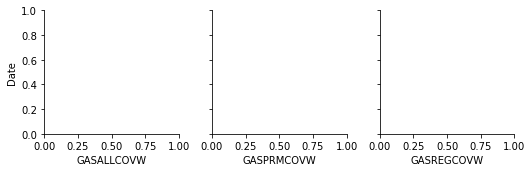

In [33]:
sns_plot = sns.pairplot(joined_gas_prices, x_vars=['GASALLCOVW', 'GASPRMCOVW', 'GASREGCOVW'], y_vars='Date')
sns_plot.savefig("output.png")